<a href="https://colab.research.google.com/github/JulianSilva2001/Image-Fitting/blob/main/Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tikzplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.9 MB/s eta 0:00:00


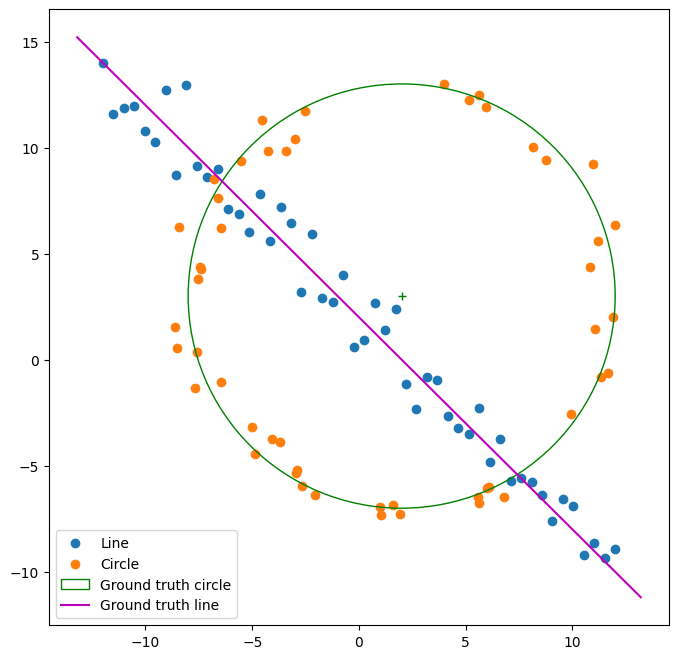

In [3]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np

# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


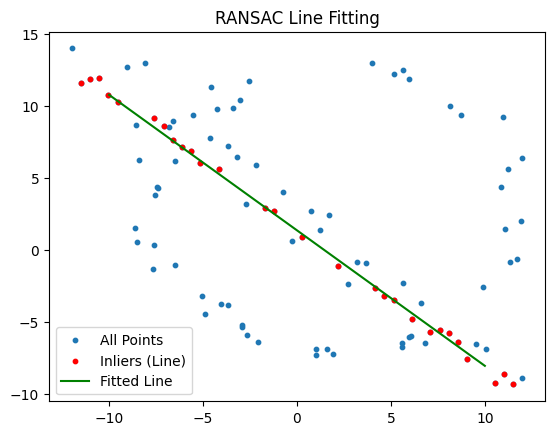

In [4]:
def fit_line_ransac(points, num_iterations=1000, distance_threshold=0.5, consensus_points=80):
    best_inliers = []
    best_line_params = None

    n = len(points)

    for _ in range(num_iterations):
        # Randomly select two points to define a line
        idx = np.random.choice(n, 2, replace=False)
        pt1, pt2 = points[idx]

        # Compute line parameters: normal vector [a, b] and distance d
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        norm = np.sqrt(dx**2 + dy**2)
        a, b = dy / norm, -dx / norm  # Unit normal vector
        d = a * pt1[0] + b * pt1[1]   # Perpendicular distance to the origin

        # Compute distances of all points to the line
        distances = np.abs(a * points[:, 0] + b * points[:, 1] - d)

        # Find inliers (points within distance_threshold of the line)
        inliers = np.where(distances < distance_threshold)[0]

        # Update best model if we found more inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_line_params = (a, b, d)

        # Stop if we have enough inliers (early stopping)
        if len(best_inliers) > consensus_points:
            break

    return best_line_params, best_inliers

# Apply RANSAC to estimate the best-fitting line
best_line_params, inliers = fit_line_ransac(X, num_iterations=1000, distance_threshold=0.5)

# Plot the inliers and the best-fitting line
plt.scatter(X[:, 0], X[:, 1], s=10, label='All Points')
plt.scatter(X[inliers, 0], X[inliers, 1], s=10, color='r', label='Inliers (Line)')

# Plot the best-fitting line
if best_line_params:
    a, b, d = best_line_params
    # Line equation: ax + by = d => y = (d - ax) / b
    x_vals = np.linspace(-10, 10, 100)
    y_vals = (d - a * x_vals) / b
    plt.plot(x_vals, y_vals, 'g-', label='Fitted Line')

plt.legend()
plt.title("RANSAC Line Fitting")
plt.show()


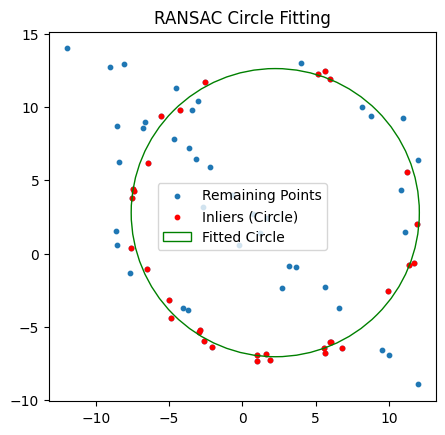

In [5]:
from scipy.optimize import minimize

def circle_from_three_points(p1, p2, p3):
    """
    Given three points, return the center and radius of the circle.
    """
    # Solve the circle from three points using geometric formulas
    A = np.array([
        [p1[0] - p2[0], p1[1] - p2[1]],
        [p1[0] - p3[0], p1[1] - p3[1]]
    ])

    b = 0.5 * np.array([
        p1[0]**2 - p2[0]**2 + p1[1]**2 - p2[1]**2,
        p1[0]**2 - p3[0]**2 + p1[1]**2 - p3[1]**2
    ])

    try:
        # Solve for the center (x_c, y_c)
        center = np.linalg.solve(A, b)
        x_c, y_c = center

        # Compute the radius
        radius = np.sqrt((p1[0] - x_c)**2 + (p1[1] - y_c)**2)
        return x_c, y_c, radius
    except np.linalg.LinAlgError:
        return None  # Points are collinear, return None

def fit_circle_ransac(points, num_iterations=1000, radial_threshold=0.5, consensus_points=60):
    best_inliers = []
    best_circle_params = None

    n = len(points)

    for _ in range(num_iterations):
        # Randomly select three points to define a circle
        idx = np.random.choice(n, 3, replace=False)
        pt1, pt2, pt3 = points[idx]

        # Estimate the circle from the three points
        circle_params = circle_from_three_points(pt1, pt2, pt3)

        if circle_params is None:
            continue  # Skip if points are collinear and no circle is found

        x_c, y_c, r = circle_params

        # Compute the radial distances of all points to the circle
        distances = np.abs(np.sqrt((points[:, 0] - x_c)**2 + (points[:, 1] - y_c)**2) - r)

        # Find inliers (points within radial_threshold of the circle)
        inliers = np.where(distances < radial_threshold)[0]

        # Update best model if we found more inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle_params = (x_c, y_c, r)

        # Stop if we have enough inliers (early stopping)
        if len(best_inliers) > consensus_points:
            break

    return best_circle_params, best_inliers

# Subtract the inliers of the best line to focus on the circle points
remaining_points = np.delete(X, inliers, axis=0)

# Apply RANSAC to estimate the best-fitting circle
best_circle_params, circle_inliers = fit_circle_ransac(remaining_points, num_iterations=1000, radial_threshold=0.5)

# Plot the remnant points and the best-fitting circle
plt.scatter(remaining_points[:, 0], remaining_points[:, 1], s=10, label='Remaining Points')
plt.scatter(remaining_points[circle_inliers, 0], remaining_points[circle_inliers, 1], s=10, color='r', label='Inliers (Circle)')

# Plot the best-fitting circle
if best_circle_params:
    x_c, y_c, r = best_circle_params
    circle = plt.Circle((x_c, y_c), r, color='g', fill=False, label='Fitted Circle')
    plt.gca().add_artist(circle)

plt.legend()
plt.title("RANSAC Circle Fitting")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


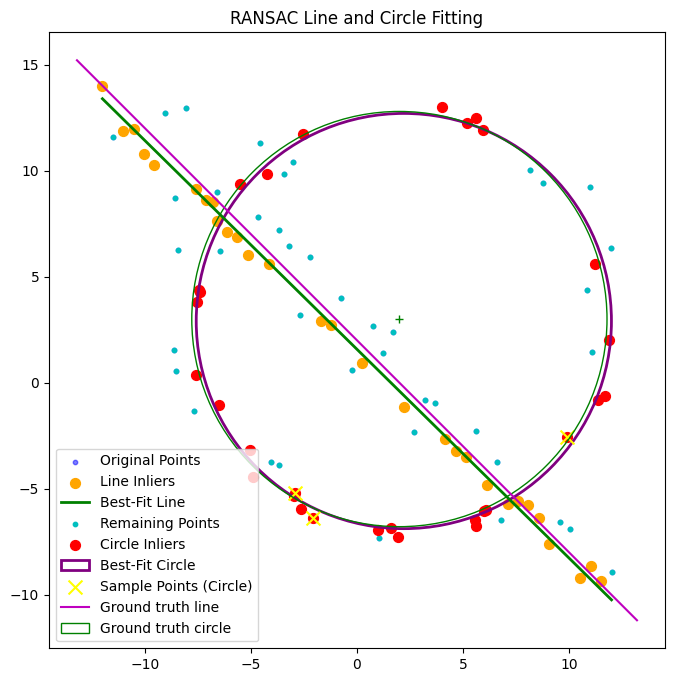

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming fit_line_ransac and fit_circle_ransac functions have been defined as in the previous step

# Generate noisy data points (as provided in Listing 1)

# 1. Fit the line using RANSAC
best_line_params, line_inliers = fit_line_ransac(X, num_iterations=1000)

# 2. Subtract line inliers and get remaining points for circle fitting
remaining_points = np.delete(X, line_inliers, axis=0)

# 3. Fit the circle using RANSAC
best_circle_params, circle_inliers = fit_circle_ransac(remaining_points, num_iterations=1000, radial_threshold=0.5)

# 4. Plot everything
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the original point set
ax.scatter(X[:, 0], X[:, 1], s=10, label='Original Points', color='b', alpha=0.5)

# Plot the line inliers
ax.scatter(X[line_inliers, 0], X[line_inliers, 1], s=50, color='orange', label='Line Inliers')

# Plot the estimated best-fit line
if best_line_params:
    a, b, d = best_line_params
    x_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    y_vals = -(a / b) * x_vals + (d / b)  # Equation of the line
    ax.plot(x_vals, y_vals, color='green', label='Best-Fit Line', linewidth=2)

# Plot the remaining points (not on the line)
ax.scatter(remaining_points[:, 0], remaining_points[:, 1], s=10, label='Remaining Points', color='c')

# Plot the circle inliers
ax.scatter(remaining_points[circle_inliers, 0], remaining_points[circle_inliers, 1], s=50, color='r', label='Circle Inliers')

# Plot the best-fit circle
if best_circle_params:
    x_c, y_c, r = best_circle_params
    circle = plt.Circle((x_c, y_c), r, color='purple', fill=False, linewidth=2, label='Best-Fit Circle')
    ax.add_artist(circle)

# Plot the three points used for circle estimation (from one RANSAC iteration)
if len(circle_inliers) > 3:
    sample_idx = np.random.choice(circle_inliers, 3, replace=False)
    ax.scatter(remaining_points[sample_idx, 0], remaining_points[sample_idx, 1], s=100, color='yellow', label='Sample Points (Circle)', marker='x')

ax.plot(x_, y_, color='m', label='Ground truth line')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')




# Set labels and legend
ax.legend()
ax.set_title("RANSAC Line and Circle Fitting")
ax.set_aspect('equal', adjustable='box')
plt.show()
